# Embrapa Wine Grape Instance Segmentation Dataset (WGISD)

## Why was the dataset created?

Embrapa WGISD (Wine Grape Instance Segmentation Dataset) was created to provide images and annotation to study
object detection and instance segmentation in image-based monitoring and field robotics for viticulture. It provides
instances from five different grape varieties taken on field. These instances shows variance in grape pose, illumination
and focus, including genetic and phenological variations as shape, color and compactness.

This notebook shows:

1. the dataset structure;
2. how to load data (using Torch `Dataset` class in 'torch.utils.data`);
3. how to visualize data using Matplotlib.

## Dataset Composition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### How many instances of each type are there?

In [ ]:
import cv2
#albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
import os
import numpy as np
import pandas as pd

## A Dataset class for PyTorch data loaders

This example shows how to load the data, getting an iterable dataset. This example uses PyTorch, but could be adapted to other deep learning frameworks.

In [ ]:
from PIL import Image

import torch, torchvision
from torch.utils.data import Dataset, DataLoader

In [ ]:
torch.__version__

'2.0.1+cu118'

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

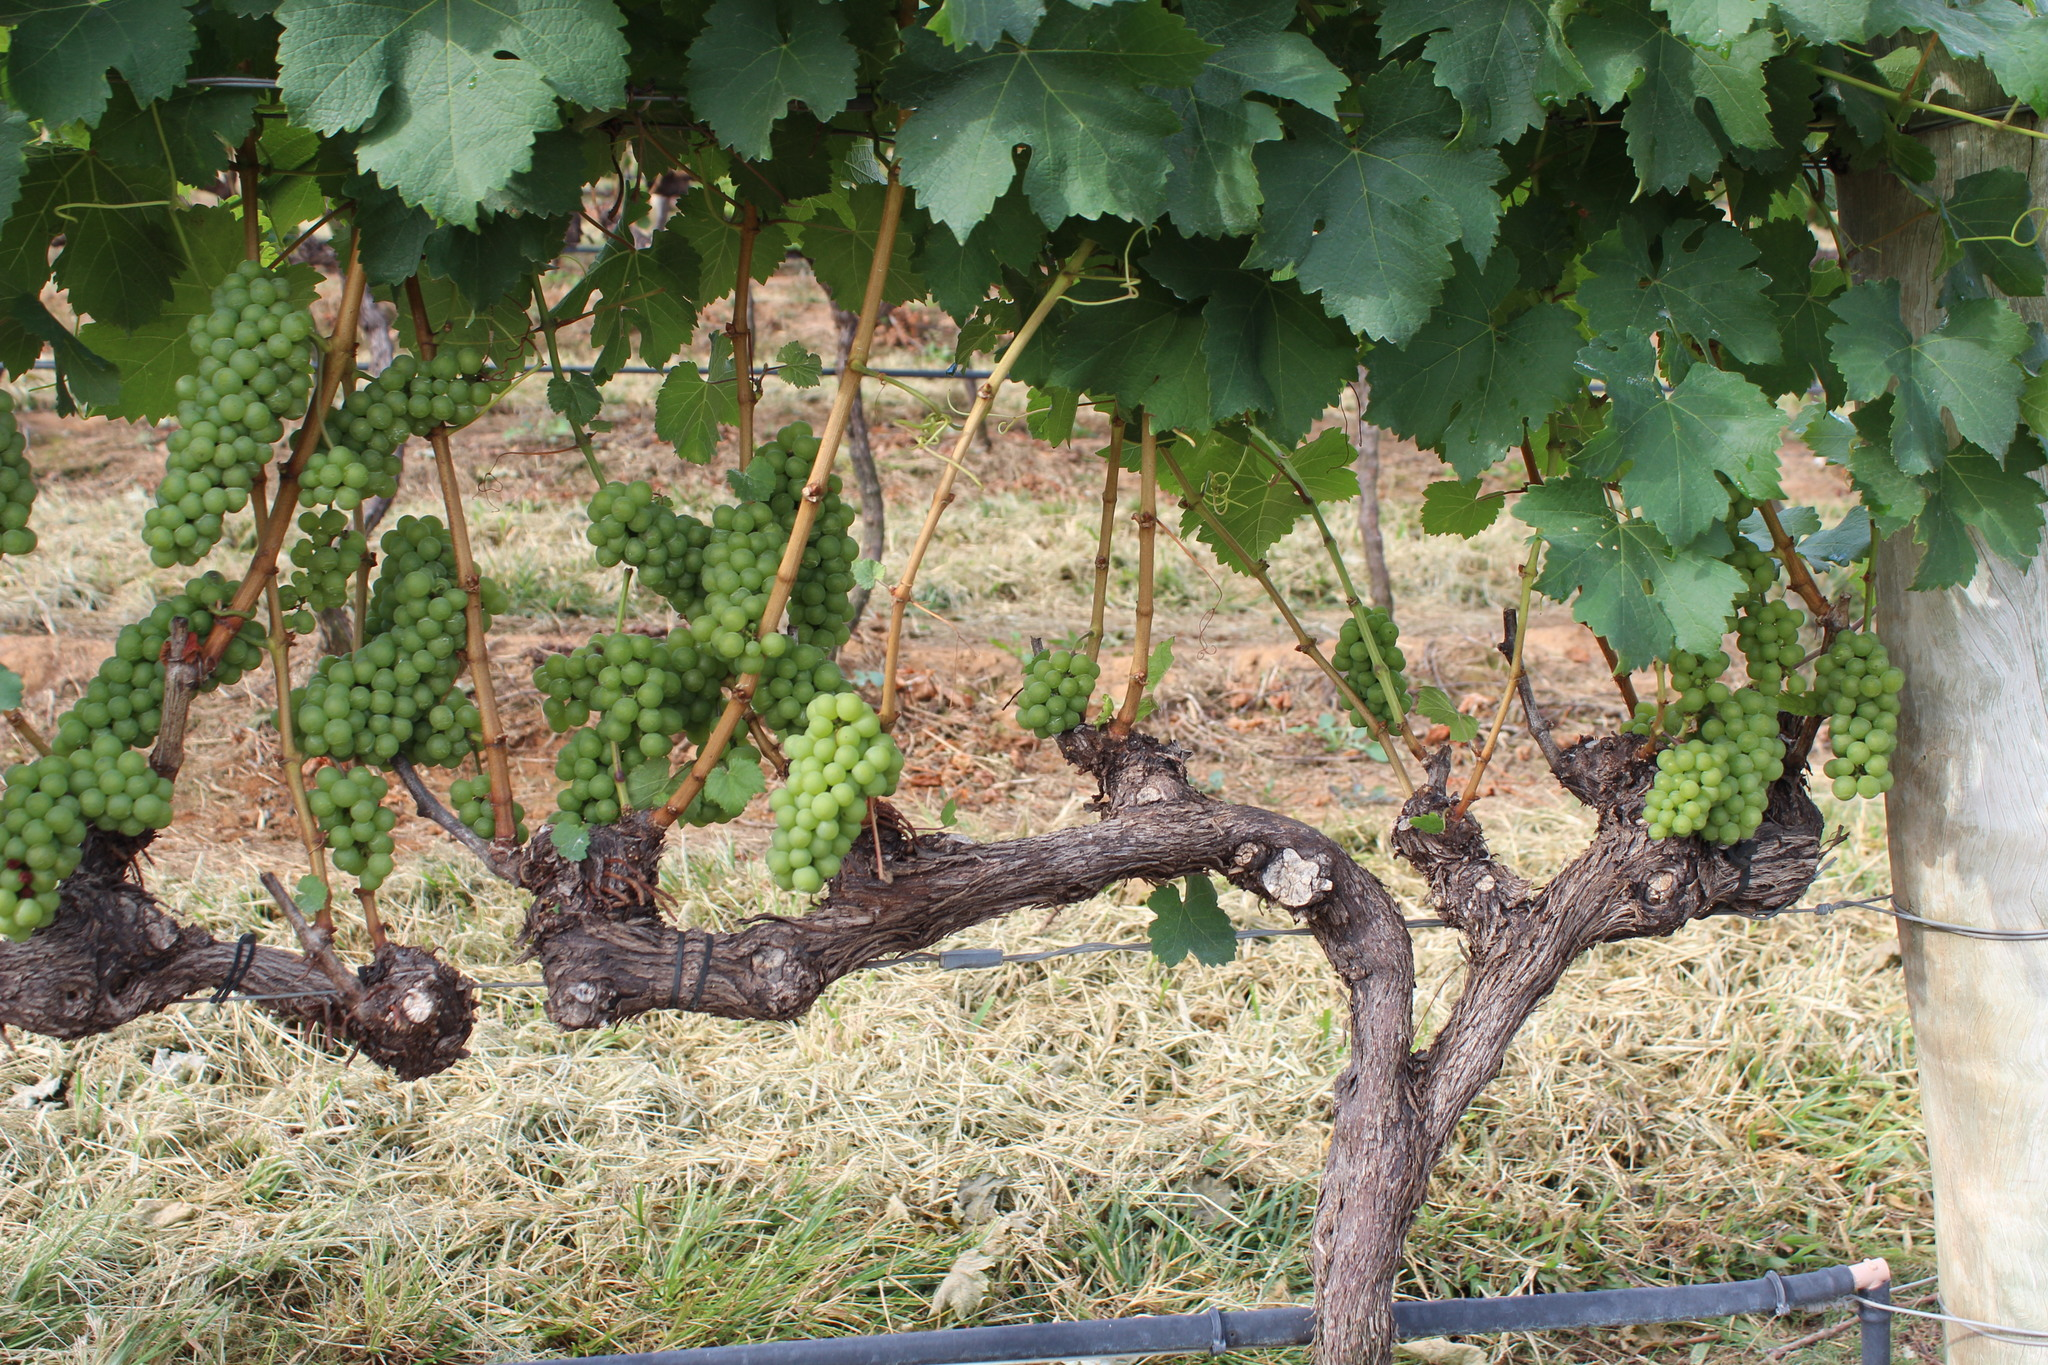

In [ ]:
image=cv2.imread("/content/drive/MyDrive/wgisd-master/wgisd-master/data/CDY_2015.jpg")
cv2_imshow(image)

In [ ]:
image.shape

(1365, 2048, 3)

In [ ]:
resize = torchvision.transforms.Resize(
    # (H, W)
    size=(512,512)
)
y = resize(torch.tensor(image).permute(2,0,1))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


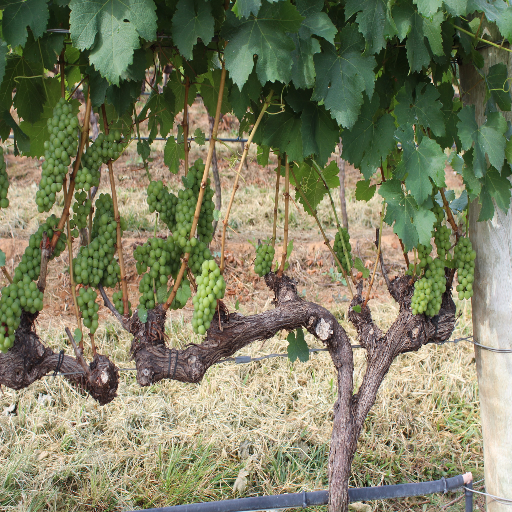

In [ ]:
image_numpy = y.numpy()

# Transpose to the correct order: (height, width, channels)
image_numpy = np.transpose(image_numpy, (1, 2, 0))

# Display the image using OpenCV
cv2_imshow(image_numpy)

In [ ]:
y

tensor([[[ 24,  24,  21,  ..., 161, 168, 191],
         [ 25,  23,  24,  ..., 154, 160, 190],
         [ 24,  23,  23,  ..., 141, 155, 174],
         ...,
         [123, 151, 210,  ..., 233, 234, 233],
         [ 57,  86,  91,  ..., 225, 235, 233],
         [ 67,  44,  31,  ..., 219, 233, 232]],

        [[ 41,  42,  42,  ..., 165, 157, 183],
         [ 40,  40,  43,  ..., 148, 159, 179],
         [ 43,  42,  43,  ..., 152, 158, 167],
         ...,
         [155, 179, 228,  ..., 241, 241, 236],
         [101, 116, 114,  ..., 232, 240, 238],
         [ 93,  70,  49,  ..., 229, 241, 240]],

        [[ 27,  28,  27,  ..., 122, 126, 150],
         [ 26,  26,  28,  ..., 111, 122, 150],
         [ 28,  27,  28,  ..., 119, 112, 133],
         ...,
         [163, 192, 225,  ..., 242, 242, 238],
         [ 88, 151, 142,  ..., 235, 243, 243],
         [114,  89,  58,  ..., 227, 240, 240]]], dtype=torch.uint8)

The following example creates a `Dataset` object for our *masked* set.

In [ ]:
class WGISDMaskedDataset(Dataset):
    def __init__(self, root, transforms=None, source='train'):
        self.root = root
        self.transforms = transforms

        # Let's load the dataset subset defined by source
        if source not in ('train', 'test'):
            print('source should by "train" or "test"')
            return None

        source_path = os.path.join(root, f'{source}_masked.txt')
        with open(source_path, 'r') as fp:
          # Read all lines in file
          lines = fp.readlines()
          # Recover the items ids, removing the \n at the end
          ids = [l.rstrip() for l in lines]

        self.imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
        self.masks = [os.path.join(root, 'data', f'{id}.npz') for id in ids]
        self.boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

    def __getitem__(self, idx):
        # Load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        box_path = self.boxes[idx]

        img = Image.open(img_path).convert("RGB")
        # print(img.shape)


        # Loading masks:
        #
        # As seen in WGISD (README.md):
        #
        # After assigning the NumPy array to a variable M, the mask for the
        # i-th grape cluster can be found in M[:,:,i]. The i-th mask corresponds
        # to the i-th line in the bounding boxes file.
        #
        # According to Mask RCNN documentation in Torchvision:
        #
        # During training, the model expects both the input tensors, as well as
        # a targets (list of dictionary), containing:
        # (...)
        # masks (UInt8Tensor[N, H, W]): the segmentation binary masks for each
        # instance
        #
        # WGISD provides [H, W, N] masks, but Torchvision asks for [N, H, W]. Lett's
        # employ NumPy moveaxis.
        wgisd_masks = np.load(mask_path)['arr_0'].astype(np.uint8)
        masks = np.moveaxis(wgisd_masks, -1, 0)

        num_objs = masks.shape[0]
        all_text = np.loadtxt(box_path, delimiter = " ", dtype = np.float32)
        wgisd_boxes = all_text[:,1:]
        # labl=all_text[:,0]
        assert(wgisd_boxes.shape[0] == num_objs)

        labels = np.ones(num_objs, dtype=np.int64)
        # iscrowd= torch.zeros((num_objs,), dtype=torch.int64)


        def setting_wsgid(img,bbox,masks):
           _, height, width = img.shape
           boxes = []
           areas= []
           for box in bbox:
                x1 = box[0] - box[2]/2
                x2 = box[0] + box[2]/2
                y1 = box[1] - box[3]/2
                y2 = box[1] + box[3]/2
                boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])
                # areas.append([x2 * width * y2 * height])

           boxes = torch.as_tensor(boxes)
          #  areas = torch.as_tensor(areas)
           masks = torch.as_tensor(masks)
           image_id = torch.tensor([idx])

           return boxes,masks,image_id

        if self.transforms is None:
            img = np.array(img)
            # Normalize
            img = (img - img.min()) / np.max([img.max() - img.min(), 1])
            # Move the channels axe to the first position, getting C, H, W instead H, W, C
            img = np.moveaxis(img, -1, 0)
            img = torch.as_tensor(img, dtype=torch.float32)
            boxes,masks,image_id=setting_wsgid(img, wgisd_boxes,masks)
            labels= torch.tensor(labels)


        else:
            img = np.array(img)
            aug_samples = self.transforms(img,wgisd_boxes,masks,labels)
            for img_augmented, boxes_augmented,masks_augmented,labels_augemented in aug_samples:
              img=img_augmented
              labels=labels_augemented

            #   masks = torch.as_tensor(masks_augmented)
              boxes,masks,image_id=setting_wsgid(img,boxes_augmented,masks_augmented)
            #   image_id = torch.tensor([idx])
            #   _, height, width = img.shape
            #   boxes = []
            #   for box in boxes_augmented:
            #     x1 = box[0] - box[2]/2
            #     x2 = box[0] + box[2]/2
            #     y1 = box[1] - box[3]/2
            #     y2 = box[1] + box[3]/2
            #     boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])
            #   boxes = torch.as_tensor(boxes)


        target = {
            "boxes": boxes,
            "masks": masks,
            "image_id": image_id,
            "labels": labels,
            # "iscrowd":iscrowd,
            # "area":areas

        }

        return img, target

    def __len__(self):
        return len(self.imgs)

The dataset class in action:

In [ ]:


def albumentations_aug(image,bboxes,mask,labels):
    # img_np= np.array(image)
    transform= A.Compose([
        ##write augumentaion to apply
        A.Resize(1024,1024),
        A.GaussianBlur(p=0.5),
        A.RandomContrast(p=0.5),
        A.GaussNoise(p=0.5),
        A.Cutout(p=0.5),
        # Add more augmentations here
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='yolo',label_fields=["category_ids"]),is_check_shapes=False)
    ##convert images, bounding boxes and masks to arrays

    aug_samples=[]

    for _ in range(1):
        augumentations= transform(image= image,bboxes=bboxes,mask=mask,category_ids=labels)
        img= augumentations["image"]
        img = np.array(img)
        # Normalize
        img = (img - img.min()) / np.max([img.max() - img.min(), 1])
        img_aug = torch.as_tensor(img, dtype=torch.float32)

        boxes_aug= augumentations["bboxes"]
        mask_aug= augumentations["mask"]
        labels_aug= torch.tensor(augumentations["category_ids"])
        aug_samples.append((img_aug, boxes_aug,mask_aug,labels_aug))
        return aug_samples

In [ ]:
training_data = WGISDMaskedDataset('/content/drive/MyDrive/wgisd-master/wgisd-master')

In [ ]:
testing_data = WGISDMaskedDataset('/content/drive/MyDrive/wgisd-master/wgisd-master',source='test')

In [ ]:
# img,target= training_data[0]
# print(img,target)

In [ ]:
training_data.__len__()

110

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataloader = DataLoader(training_data,batch_size=8,shuffle=True, collate_fn=collate_fn)
test_dataloader=  DataLoader(training_data,batch_size=8,shuffle=True,collate_fn=collate_fn)


In [ ]:
train_dataloader.__len__()

14

pytorch can't handel dynamic sizes in batches

https://stackoverflow.com/questions/62719641/why-pytorch-model-takes-multiple-image-size-inside-the-model

In [ ]:
# Display image and label.
# train_features, train_target = next(iter(train_dataloader))




# This ends

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from tqdm.auto import tqdm

In [ ]:
num_classes = 2
# load an instance segmentation model pre-trained pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
model=model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
from tqdm import tqdm
torch.manual_seed(42)
epochs=100
loss_list = []
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device="cpu"
for epoch in tqdm(range(epochs)):
    print(f"Epoch:{epoch} \n ----")
    train_loss=[]
    for batch,(images,targets) in enumerate(train_dataloader):
        images= list(image.to(device) for image in images)
        targets= [{k:v.to(device) for k,v in target.items()} for target in targets]
        optimizer.zero_grad()
        model=model.float()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        train_loss.append(losses.item())
        print(f"loss for Batch {batch} : {losses.item()}")
    train_loss_mean = np.mean(train_loss)
    loss_list.append(train_loss_mean)
    print("Average loss for epoch = {:.4f} ".format(train_loss_mean))





  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:0 
 ----
loss for Batch 0 : 5.947474161928667
loss for Batch 1 : 3.158078652233851
loss for Batch 2 : 2.7767778907794125
loss for Batch 3 : 2.4818981451679774
loss for Batch 4 : 2.2101764660720002
loss for Batch 5 : 2.1805844274997592
loss for Batch 6 : 2.1462777030969824
loss for Batch 7 : 2.0537261080090268
loss for Batch 8 : 1.965442561568866
loss for Batch 9 : 1.8602102409183934
loss for Batch 10 : 1.85176122086083
loss for Batch 11 : 1.9267100519119966
loss for Batch 12 : 1.8741175720235088


  1%|          | 1/100 [04:05<6:45:12, 245.58s/it]

loss for Batch 13 : 1.775326061143776
Average loss for epoch = 2.4435 
Epoch:1 
 ----
loss for Batch 0 : 1.5915175382195106
loss for Batch 1 : 1.811298024165607
loss for Batch 2 : 1.7322248085618888
loss for Batch 3 : 1.700957383081084
loss for Batch 4 : 1.7187056510321386
loss for Batch 5 : 1.6567023318983787
loss for Batch 6 : 1.671802411127484
loss for Batch 7 : 1.5560693958118952
loss for Batch 8 : 1.5164036016986884
loss for Batch 9 : 1.7027497857937273
loss for Batch 10 : 1.6044426644423648
loss for Batch 11 : 1.5948768257032273
loss for Batch 12 : 1.5373238938158464


  2%|▏         | 2/100 [06:34<5:08:35, 188.94s/it]

loss for Batch 13 : 1.4130809778434523
Average loss for epoch = 1.6292 
Epoch:2 
 ----
loss for Batch 0 : 1.4303260131714803
loss for Batch 1 : 1.4181471058868984
loss for Batch 2 : 1.3759282827161008
loss for Batch 3 : 1.525471664341198
loss for Batch 4 : 1.455945650454177
loss for Batch 5 : 1.5104834825514524
loss for Batch 6 : 1.315415068683955
loss for Batch 7 : 1.4258575092354653
loss for Batch 8 : 1.2959355447223657
loss for Batch 9 : 1.2169933686244927
loss for Batch 10 : 1.4126482930318505
loss for Batch 11 : 1.2563074721829006
loss for Batch 12 : 1.3141110937235705


  3%|▎         | 3/100 [09:02<4:34:39, 169.90s/it]

loss for Batch 13 : 1.2495659130762249
Average loss for epoch = 1.3717 
Epoch:3 
 ----
loss for Batch 0 : 1.3461671869653855
loss for Batch 1 : 1.197328504119451
loss for Batch 2 : 1.2651886570696211
loss for Batch 3 : 1.2875594475714383
loss for Batch 4 : 1.1294318935172387
loss for Batch 5 : 1.2240298706014618
loss for Batch 6 : 1.114835187207303
loss for Batch 7 : 1.1647581630760522
loss for Batch 8 : 1.1468095958001967
loss for Batch 9 : 1.0457007223286885
loss for Batch 10 : 1.1145039424895882
loss for Batch 11 : 1.0938547631811155
loss for Batch 12 : 1.186356013355837


  4%|▍         | 4/100 [11:28<4:17:16, 160.80s/it]

loss for Batch 13 : 1.1528474283225598
Average loss for epoch = 1.1764 
Epoch:4 
 ----
loss for Batch 0 : 1.0769080142229537
loss for Batch 1 : 1.1191046586957816
loss for Batch 2 : 1.068673308038149
loss for Batch 3 : 1.0959507845592247
loss for Batch 4 : 1.026102425942507
loss for Batch 5 : 0.9807978196044199
loss for Batch 6 : 1.0656530012705792
loss for Batch 7 : 1.0511134639728388
loss for Batch 8 : 0.9775527863761126
loss for Batch 9 : 1.055838753808628
loss for Batch 10 : 1.1599413066286273
loss for Batch 11 : 1.145875667278015
loss for Batch 12 : 1.0298601221188337


  5%|▌         | 5/100 [13:55<4:06:36, 155.75s/it]

loss for Batch 13 : 1.0856127724597022
Average loss for epoch = 1.0671 
Epoch:5 
 ----
loss for Batch 0 : 1.0591326877974887
loss for Batch 1 : 0.9510116106873931
loss for Batch 2 : 0.9445483777662679
loss for Batch 3 : 0.9551950062756579
loss for Batch 4 : 1.008220988561401
loss for Batch 5 : 1.0348048970595258
loss for Batch 6 : 0.9578028092823263
loss for Batch 7 : 0.9851023406741969
loss for Batch 8 : 1.127475191913877
loss for Batch 9 : 0.9676036622044459
loss for Batch 10 : 1.0146141517525047
loss for Batch 11 : 1.009905823053843
loss for Batch 12 : 1.0017124659451133


  6%|▌         | 6/100 [16:21<3:58:44, 152.39s/it]

loss for Batch 13 : 0.9857950435720202
Average loss for epoch = 1.0002 
Epoch:6 
 ----
loss for Batch 0 : 1.0547539032672604
loss for Batch 1 : 0.9599097898974824
loss for Batch 2 : 0.8547202661588541
loss for Batch 3 : 0.9338882052248341
loss for Batch 4 : 0.9603101211592028
loss for Batch 5 : 1.0117877157450021
loss for Batch 6 : 0.8992310584985844
loss for Batch 7 : 0.9269080867777495
loss for Batch 8 : 0.7655267739889539
loss for Batch 9 : 1.0319190445886146
loss for Batch 10 : 0.9933462648325267
loss for Batch 11 : 0.9473598160731564
loss for Batch 12 : 0.9534458150673115


  7%|▋         | 7/100 [18:48<3:53:36, 150.71s/it]

loss for Batch 13 : 0.9441210135820908
Average loss for epoch = 0.9455 
Epoch:7 
 ----
loss for Batch 0 : 0.9024184972588185
loss for Batch 1 : 0.989845133608328
loss for Batch 2 : 1.008478369721969
loss for Batch 3 : 0.9152816052541414
loss for Batch 4 : 0.7333202449183756
loss for Batch 5 : 0.8793654358304748
loss for Batch 6 : 0.8965476116867314
loss for Batch 7 : 0.9271124398090984
loss for Batch 8 : 0.9522886615390043
loss for Batch 9 : 0.8767127773254159
loss for Batch 10 : 0.8937988641868312
loss for Batch 11 : 0.9506766599967806
loss for Batch 12 : 0.9193046015017943


  8%|▊         | 8/100 [21:17<3:50:05, 150.06s/it]

loss for Batch 13 : 0.7213508790073686
Average loss for epoch = 0.8976 
Epoch:8 
 ----
loss for Batch 0 : 0.830640386068843
loss for Batch 1 : 0.7702021606749139
loss for Batch 2 : 0.8587585060834425
loss for Batch 3 : 0.9389565859231852
loss for Batch 4 : 0.768239758756528
loss for Batch 5 : 0.7749853524170661
loss for Batch 6 : 0.8848751072948857
loss for Batch 7 : 0.8327042276480192
loss for Batch 8 : 0.8456437508345452
loss for Batch 9 : 0.9495134594930437
loss for Batch 10 : 0.9529036980207479
loss for Batch 11 : 0.9410987582296418
loss for Batch 12 : 0.8034857022622336


  9%|▉         | 9/100 [23:45<3:46:40, 149.46s/it]

loss for Batch 13 : 0.9103006773923197
Average loss for epoch = 0.8616 
Epoch:9 
 ----
loss for Batch 0 : 1.0067078680665948
loss for Batch 1 : 0.7919574398638729
loss for Batch 2 : 0.8399567219628497
loss for Batch 3 : 0.7109314394958713
loss for Batch 4 : 0.8251979036523529
loss for Batch 5 : 0.8708586053720571
loss for Batch 6 : 0.7182359577538204
loss for Batch 7 : 0.7969457607438212
loss for Batch 8 : 0.837054855995476
loss for Batch 9 : 0.8010840486900515
loss for Batch 10 : 0.8962214626649118
loss for Batch 11 : 0.8471281829271935
loss for Batch 12 : 0.752343702655165


 10%|█         | 10/100 [26:12<3:43:09, 148.77s/it]

loss for Batch 13 : 0.8384689129698446
Average loss for epoch = 0.8238 
Epoch:10 
 ----
loss for Batch 0 : 0.856535037428447
loss for Batch 1 : 0.8202309946462326
loss for Batch 2 : 0.8382132911000684
loss for Batch 3 : 0.726280074739841
loss for Batch 4 : 0.822669216337405
loss for Batch 5 : 0.702103517591608
loss for Batch 6 : 0.67875460346508
loss for Batch 7 : 0.8028020827588506
loss for Batch 8 : 0.7041824403930682
loss for Batch 9 : 0.7961434544627286
loss for Batch 10 : 0.7960381978423987
loss for Batch 11 : 0.7410183274992299
loss for Batch 12 : 0.8009277506707766


 11%|█         | 11/100 [28:39<3:39:45, 148.16s/it]

loss for Batch 13 : 0.8068070279037648
Average loss for epoch = 0.7781 
Epoch:11 
 ----
loss for Batch 0 : 0.8654871374992915
loss for Batch 1 : 0.8336537505507479
loss for Batch 2 : 0.8746792338937778
loss for Batch 3 : 0.7355566194203547
loss for Batch 4 : 0.7825662692987839
loss for Batch 5 : 0.7650960833274975
loss for Batch 6 : 0.7835720166856648
loss for Batch 7 : 0.6838560532643875
loss for Batch 8 : 0.7293654815655525
loss for Batch 9 : 0.7768346196268338
loss for Batch 10 : 0.6885656640434084
loss for Batch 11 : 0.816049405538777
loss for Batch 12 : 0.6011109787998736


 12%|█▏        | 12/100 [31:06<3:36:40, 147.74s/it]

loss for Batch 13 : 0.7253212996141172
Average loss for epoch = 0.7616 
Epoch:12 
 ----
loss for Batch 0 : 0.6534214240018369
loss for Batch 1 : 0.6181586237397199
loss for Batch 2 : 0.639051652792962
loss for Batch 3 : 0.7289896094718401
loss for Batch 4 : 0.7834081328651685
loss for Batch 5 : 0.8150548821071854
loss for Batch 6 : 0.6484090440496026
loss for Batch 7 : 0.7488793855117594
loss for Batch 8 : 0.7373105817757932
loss for Batch 9 : 0.7119405512194984
loss for Batch 10 : 0.7610535704795666
loss for Batch 11 : 0.8071456842571315
loss for Batch 12 : 0.7631896051576336


 13%|█▎        | 13/100 [33:33<3:34:02, 147.62s/it]

loss for Batch 13 : 0.7372809011534752
Average loss for epoch = 0.7252 
Epoch:13 
 ----
loss for Batch 0 : 0.6781658895364487
loss for Batch 1 : 0.7023716321557156
loss for Batch 2 : 0.6222185262952004
loss for Batch 3 : 0.6332526166662079
loss for Batch 4 : 0.7350129509965934
loss for Batch 5 : 0.7256836575440799
loss for Batch 6 : 0.6677845341440896
loss for Batch 7 : 0.7148888188517294
loss for Batch 8 : 0.6471866636281647
loss for Batch 9 : 0.6743970652157983
loss for Batch 10 : 0.7622544459277238
loss for Batch 11 : 0.6940479375615818
loss for Batch 12 : 0.703749566227952


 14%|█▍        | 14/100 [36:01<3:31:35, 147.62s/it]

loss for Batch 13 : 0.8424739659936312
Average loss for epoch = 0.7002 
Epoch:14 
 ----
loss for Batch 0 : 0.6695234045605954
loss for Batch 1 : 0.6188283696227124
loss for Batch 2 : 0.6676906760260896
loss for Batch 3 : 0.6865307235120429
loss for Batch 4 : 0.6659716143393354
loss for Batch 5 : 0.6394925241751936
loss for Batch 6 : 0.5817569022936824
loss for Batch 7 : 0.7112036942517845
loss for Batch 8 : 0.6086857307208677
loss for Batch 9 : 0.7414868270410494
loss for Batch 10 : 0.7826033557010119
loss for Batch 11 : 0.7445110121041303
loss for Batch 12 : 0.6590814638057895


 15%|█▌        | 15/100 [38:29<3:29:24, 147.82s/it]

loss for Batch 13 : 0.690361698891538
Average loss for epoch = 0.6763 
Epoch:15 
 ----
loss for Batch 0 : 0.8094685745792167
loss for Batch 1 : 0.6319514975943948
loss for Batch 2 : 0.6633225225191235
loss for Batch 3 : 0.7097921937121041
loss for Batch 4 : 0.6046759843061507
loss for Batch 5 : 0.6255546502858199
loss for Batch 6 : 0.6473864930144853
loss for Batch 7 : 0.585986536475794
loss for Batch 8 : 0.5730430809703038
loss for Batch 9 : 0.644590517500768
loss for Batch 10 : 0.6676087471091003
loss for Batch 11 : 0.6325374415540785
loss for Batch 12 : 0.6627208767801362


 16%|█▌        | 16/100 [40:57<3:27:00, 147.86s/it]

loss for Batch 13 : 0.7564384272582416
Average loss for epoch = 0.6582 
Epoch:16 
 ----
loss for Batch 0 : 0.6181136998604452
loss for Batch 1 : 0.6499234670226788
loss for Batch 2 : 0.6702682272115513
loss for Batch 3 : 0.6269877701711936
loss for Batch 4 : 0.5641142288880829
loss for Batch 5 : 0.6517375597191458
loss for Batch 6 : 0.580862816884808
loss for Batch 7 : 0.7464082530052735
loss for Batch 8 : 0.5289565700103562
loss for Batch 9 : 0.6543650869819697
loss for Batch 10 : 0.6439068682630789
loss for Batch 11 : 0.5833603480674109
loss for Batch 12 : 0.595850272935897


 17%|█▋        | 17/100 [43:25<3:24:23, 147.76s/it]

loss for Batch 13 : 0.6845774368767579
Average loss for epoch = 0.6285 
Epoch:17 
 ----
loss for Batch 0 : 0.6302956161374873
loss for Batch 1 : 0.6104103103312586
loss for Batch 2 : 0.5518547128940159
loss for Batch 3 : 0.6215340699003776
loss for Batch 4 : 0.681060266083997
loss for Batch 5 : 0.6613216071677367
loss for Batch 6 : 0.5249058948421386
loss for Batch 7 : 0.430782822650654
loss for Batch 8 : 0.6420808666660545
loss for Batch 9 : 0.6490834562124018
loss for Batch 10 : 0.6376480628657715
loss for Batch 11 : 0.6173973890089687
loss for Batch 12 : 0.6064149390020394


 18%|█▊        | 18/100 [45:53<3:22:01, 147.82s/it]

loss for Batch 13 : 0.6291654545703701
Average loss for epoch = 0.6067 
Epoch:18 
 ----
loss for Batch 0 : 0.4320815354613484
loss for Batch 1 : 0.6335807692285093
loss for Batch 2 : 0.6235561187989755
loss for Batch 3 : 0.6033033598820544
loss for Batch 4 : 0.5528531707886399
loss for Batch 5 : 0.5684228411649505
loss for Batch 6 : 0.6145503454969397
loss for Batch 7 : 0.6208864400530999
loss for Batch 8 : 0.6356645246357762
loss for Batch 9 : 0.596910825705067
loss for Batch 10 : 0.6060403347105948
loss for Batch 11 : 0.5706852918515576
loss for Batch 12 : 0.6166245487069376


 19%|█▉        | 19/100 [48:21<3:19:40, 147.90s/it]

loss for Batch 13 : 0.5916176725877202
Average loss for epoch = 0.5905 
Epoch:19 
 ----
loss for Batch 0 : 0.5763570782418843
loss for Batch 1 : 0.6551202544881987
loss for Batch 2 : 0.5791594062858915
loss for Batch 3 : 0.5674591232256434
loss for Batch 4 : 0.5772340419136631
loss for Batch 5 : 0.5528261937931179
loss for Batch 6 : 0.5582008025461308
loss for Batch 7 : 0.5305589236284772
loss for Batch 8 : 0.6186154196291843
loss for Batch 9 : 0.6123116963725814
loss for Batch 10 : 0.5880686253531258
loss for Batch 11 : 0.4724681886082511
loss for Batch 12 : 0.6007753338139955


 20%|██        | 20/100 [50:47<3:16:40, 147.51s/it]

loss for Batch 13 : 0.534951591755126
Average loss for epoch = 0.5732 
Epoch:20 
 ----
loss for Batch 0 : 0.5275438947103674
loss for Batch 1 : 0.6427228133982423
loss for Batch 2 : 0.5952805838864754
loss for Batch 3 : 0.5096143841017446
loss for Batch 4 : 0.5578264387125735
loss for Batch 5 : 0.551300342618683
loss for Batch 6 : 0.4891693875337005
loss for Batch 7 : 0.6175797393174342
loss for Batch 8 : 0.5289555856112466
loss for Batch 9 : 0.6025605582206567
loss for Batch 10 : 0.5131977066053892
loss for Batch 11 : 0.5487989883674949
loss for Batch 12 : 0.6027686128577846


 21%|██        | 21/100 [53:16<3:14:39, 147.84s/it]

loss for Batch 13 : 0.5294488657755991
Average loss for epoch = 0.5583 
Epoch:21 
 ----
loss for Batch 0 : 0.46484673780179264
loss for Batch 1 : 0.5536867453878697
loss for Batch 2 : 0.5775561436682881
loss for Batch 3 : 0.5831728619960305
loss for Batch 4 : 0.4906048435436132
loss for Batch 5 : 0.5854462382640276
loss for Batch 6 : 0.5207150262799891
loss for Batch 7 : 0.5624953324899022
loss for Batch 8 : 0.5676320892423811
loss for Batch 9 : 0.481165542478088
loss for Batch 10 : 0.5701711518725937
loss for Batch 11 : 0.6023360924516474
loss for Batch 12 : 0.5394552423687026


 22%|██▏       | 22/100 [55:43<3:12:02, 147.73s/it]

loss for Batch 13 : 0.5742706728311708
Average loss for epoch = 0.5481 
Epoch:22 
 ----
loss for Batch 0 : 0.5337741807830576
loss for Batch 1 : 0.5457416219558517
loss for Batch 2 : 0.5144327357979018
loss for Batch 3 : 0.5488152037055788
loss for Batch 4 : 0.5906820788265327
loss for Batch 5 : 0.4779171505372277
loss for Batch 6 : 0.5235786717936127
loss for Batch 7 : 0.5005966012059286
loss for Batch 8 : 0.5382090500232528
loss for Batch 9 : 0.5073687894748906
loss for Batch 10 : 0.4704231701776575
loss for Batch 11 : 0.6035092256810904
loss for Batch 12 : 0.5440944087423342


 23%|██▎       | 23/100 [58:11<3:09:28, 147.64s/it]

loss for Batch 13 : 0.561988425969317
Average loss for epoch = 0.5329 
Epoch:23 
 ----
loss for Batch 0 : 0.5526085196308245
loss for Batch 1 : 0.5703670492070056
loss for Batch 2 : 0.5754798778565492
loss for Batch 3 : 0.5230692631643308
loss for Batch 4 : 0.4734624256815752
loss for Batch 5 : 0.44026977976837134
loss for Batch 6 : 0.5301168544505412
loss for Batch 7 : 0.5186059314774843
loss for Batch 8 : 0.5116482922379735
loss for Batch 9 : 0.49742090620557766
loss for Batch 10 : 0.5710081731690496
loss for Batch 11 : 0.507676776873211
loss for Batch 12 : 0.4866033883065379


 24%|██▍       | 24/100 [1:00:39<3:07:16, 147.85s/it]

loss for Batch 13 : 0.5617532690186434
Average loss for epoch = 0.5229 
Epoch:24 
 ----
loss for Batch 0 : 0.45194441901737964
loss for Batch 1 : 0.5364888939182124
loss for Batch 2 : 0.540150986657703
loss for Batch 3 : 0.4712715413016476
loss for Batch 4 : 0.5586722761070898
loss for Batch 5 : 0.4873803655054508
loss for Batch 6 : 0.4621207654448069
loss for Batch 7 : 0.5341113924569802
loss for Batch 8 : 0.552563878895079
loss for Batch 9 : 0.5252841198061721
loss for Batch 10 : 0.5727203782482253
loss for Batch 11 : 0.4761879614386868
loss for Batch 12 : 0.44903922540621555


 25%|██▌       | 25/100 [1:03:07<3:04:43, 147.78s/it]

loss for Batch 13 : 0.5391509095590019
Average loss for epoch = 0.5112 
Epoch:25 
 ----
loss for Batch 0 : 0.5561766134082722
loss for Batch 1 : 0.45602402082099014
loss for Batch 2 : 0.5680513910323344
loss for Batch 3 : 0.4913617191992264
loss for Batch 4 : 0.49617497563495955
loss for Batch 5 : 0.49091110085347
loss for Batch 6 : 0.5156324017038043
loss for Batch 7 : 0.4997165328769027
loss for Batch 8 : 0.505705727450105
loss for Batch 9 : 0.4889296520906104
loss for Batch 10 : 0.5016263781598796
loss for Batch 11 : 0.4353127298100677
loss for Batch 12 : 0.45665538702154795


 26%|██▌       | 26/100 [1:05:35<3:02:26, 147.92s/it]

loss for Batch 13 : 0.44712625946755513
Average loss for epoch = 0.4935 
Epoch:26 
 ----
loss for Batch 0 : 0.42236912450992237
loss for Batch 1 : 0.46906976175140563
loss for Batch 2 : 0.468976623838167
loss for Batch 3 : 0.4816965107455093
loss for Batch 4 : 0.5078643608916337
loss for Batch 5 : 0.48210477921058414
loss for Batch 6 : 0.5207069012671574
loss for Batch 7 : 0.4959572673220293
loss for Batch 8 : 0.43352881436174023
loss for Batch 9 : 0.4134888249247226
loss for Batch 10 : 0.48699849226032066
loss for Batch 11 : 0.5242126053415721
loss for Batch 12 : 0.5427347750579166


 27%|██▋       | 27/100 [1:08:04<3:00:31, 148.37s/it]

loss for Batch 13 : 0.5171178947078855
Average loss for epoch = 0.4833 
Epoch:27 
 ----
loss for Batch 0 : 0.4617336443700942
loss for Batch 1 : 0.48429752629431055
loss for Batch 2 : 0.4482323717873451
loss for Batch 3 : 0.45714601300390406
loss for Batch 4 : 0.4819093075057982
loss for Batch 5 : 0.41333007467356425
loss for Batch 6 : 0.4628465900492279
loss for Batch 7 : 0.4302836040479869
loss for Batch 8 : 0.5293667208323914
loss for Batch 9 : 0.44655206764399114
loss for Batch 10 : 0.4578896371879058
loss for Batch 11 : 0.524336763315926
loss for Batch 12 : 0.46535932755144177


 28%|██▊       | 28/100 [1:10:33<2:57:59, 148.32s/it]

loss for Batch 13 : 0.5541605945910583
Average loss for epoch = 0.4727 
Epoch:28 
 ----
loss for Batch 0 : 0.4416914618145312
loss for Batch 1 : 0.4823064775710737
loss for Batch 2 : 0.515762145978255
loss for Batch 3 : 0.42601603801854415
loss for Batch 4 : 0.4221789887899986
loss for Batch 5 : 0.3788005061719568
loss for Batch 6 : 0.4447816550595034
loss for Batch 7 : 0.4984735471526222
loss for Batch 8 : 0.4226945179123943
loss for Batch 9 : 0.5319700431818813
loss for Batch 10 : 0.5228064099575038
loss for Batch 11 : 0.4907036671040586
loss for Batch 12 : 0.43597296397094487


 29%|██▉       | 29/100 [1:13:01<2:55:24, 148.24s/it]

loss for Batch 13 : 0.48050110132378815
Average loss for epoch = 0.4639 
Epoch:29 
 ----
loss for Batch 0 : 0.49836859382983206
loss for Batch 1 : 0.4808525934492637
loss for Batch 2 : 0.4264581383828282
loss for Batch 3 : 0.45787629101512733
loss for Batch 4 : 0.38666035819868294
loss for Batch 5 : 0.45273894429356537
loss for Batch 6 : 0.4823688948593745
loss for Batch 7 : 0.44267137997554495
loss for Batch 8 : 0.43788601890181744
loss for Batch 9 : 0.4239170659115356
loss for Batch 10 : 0.5217028633760127
loss for Batch 11 : 0.45657901794050115
loss for Batch 12 : 0.4877902884247474


 30%|███       | 30/100 [1:15:28<2:52:29, 147.86s/it]

loss for Batch 13 : 0.42403470667909265
Average loss for epoch = 0.4557 
Epoch:30 
 ----
loss for Batch 0 : 0.43992423145716664
loss for Batch 1 : 0.4942855647260797
loss for Batch 2 : 0.45923493671517557
loss for Batch 3 : 0.45378490070169886
loss for Batch 4 : 0.47089006623030183
loss for Batch 5 : 0.41620572223101704
loss for Batch 6 : 0.41453433737588485
loss for Batch 7 : 0.4618824584104813
loss for Batch 8 : 0.3883108244474652
loss for Batch 9 : 0.4957805151408184
loss for Batch 10 : 0.48864860039383995
loss for Batch 11 : 0.4840061249211705
loss for Batch 12 : 0.38190364101983204


 31%|███       | 31/100 [1:17:55<2:49:43, 147.58s/it]

loss for Batch 13 : 0.49375257958958063
Average loss for epoch = 0.4531 
Epoch:31 
 ----
loss for Batch 0 : 0.40545221975574547
loss for Batch 1 : 0.5113561972708638
loss for Batch 2 : 0.43765076465814134
loss for Batch 3 : 0.46699239554412203
loss for Batch 4 : 0.44322904532643964
loss for Batch 5 : 0.43479389320160955
loss for Batch 6 : 0.4109687545542905
loss for Batch 7 : 0.40357278159209087
loss for Batch 8 : 0.4686383083986031
loss for Batch 9 : 0.40255064235767113
loss for Batch 10 : 0.4842228495407894
loss for Batch 11 : 0.48195771124708325
loss for Batch 12 : 0.4310344408179733


 32%|███▏      | 32/100 [1:20:21<2:46:44, 147.13s/it]

loss for Batch 13 : 0.36664742870543515
Average loss for epoch = 0.4392 
Epoch:32 
 ----
loss for Batch 0 : 0.412756734213122
loss for Batch 1 : 0.42413469360017575
loss for Batch 2 : 0.35008900018146655
loss for Batch 3 : 0.42330940060518957
loss for Batch 4 : 0.5130465236280148
loss for Batch 5 : 0.4166455747904096
loss for Batch 6 : 0.3949183100489664
loss for Batch 7 : 0.47662649636418797
loss for Batch 8 : 0.4544653948929766
loss for Batch 9 : 0.41950230648198855
loss for Batch 10 : 0.43717627824412425
loss for Batch 11 : 0.4300039559794069
loss for Batch 12 : 0.4652400772707937


 33%|███▎      | 33/100 [1:22:47<2:44:02, 146.90s/it]

loss for Batch 13 : 0.44559200761471707
Average loss for epoch = 0.4331 
Epoch:33 
 ----
loss for Batch 0 : 0.402315193984665
loss for Batch 1 : 0.35593793757938114
loss for Batch 2 : 0.4308988596183254
loss for Batch 3 : 0.3762133178783919
loss for Batch 4 : 0.43334108861776305
loss for Batch 5 : 0.4464163023160546
loss for Batch 6 : 0.5229064685843607
loss for Batch 7 : 0.4141237415796547
loss for Batch 8 : 0.4756265960584029
loss for Batch 9 : 0.47143636741749234
loss for Batch 10 : 0.37155566707945004
loss for Batch 11 : 0.4337385787823993
loss for Batch 12 : 0.4056444476279445


 34%|███▍      | 34/100 [1:25:14<2:41:26, 146.77s/it]

loss for Batch 13 : 0.3832781812701761
Average loss for epoch = 0.4231 
Epoch:34 
 ----
loss for Batch 0 : 0.3833394511706035
loss for Batch 1 : 0.3709764862562313
loss for Batch 2 : 0.39627172207510586
loss for Batch 3 : 0.41357774556426313
loss for Batch 4 : 0.3796986738983464
loss for Batch 5 : 0.46932652187049845
loss for Batch 6 : 0.4158884930426377
loss for Batch 7 : 0.39945027247032877
loss for Batch 8 : 0.44089636550905
loss for Batch 9 : 0.4640108338680904
loss for Batch 10 : 0.4335115083182022
loss for Batch 11 : 0.4225720900807992
loss for Batch 12 : 0.40102423988615576


 35%|███▌      | 35/100 [1:27:40<2:39:01, 146.79s/it]

loss for Batch 13 : 0.4368326616763152
Average loss for epoch = 0.4162 
Epoch:35 
 ----
loss for Batch 0 : 0.42026996357171187
loss for Batch 1 : 0.42837417713719095
loss for Batch 2 : 0.39565482795467716
loss for Batch 3 : 0.4156396472801014
loss for Batch 4 : 0.3954857109899434
loss for Batch 5 : 0.38533079724058134
loss for Batch 6 : 0.435067678147303
loss for Batch 7 : 0.45064604252416224
loss for Batch 8 : 0.3775758906450567
loss for Batch 9 : 0.3533342411323973
loss for Batch 10 : 0.36569463696565896
loss for Batch 11 : 0.4066873230205574
loss for Batch 12 : 0.46640610876342453


In [ ]:
!pip install torchmetrics
import torchmetrics

In [ ]:
from torchmetrics.detection import MeanAveragePrecision
from pprint import pprint
from torchmetrics.detection import IntersectionOverUnion

In [ ]:
test_loss = 0
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.eval()

metric = MeanAveragePrecision().to(device)

with torch.inference_mode():
    for batch, (images, targets) in enumerate(test_dataloader):
        images = [image.to(device) for image in images]  # Move each image to the device
        targets= [{k:v.to(device) for k,v in target.items()} for target in targets]
        test_pred = model(images)

            # Update the metric with predictions and targets
        metric.update(test_pred, targets)

mAP_value = metric.compute()

# Now you can plot the metric (if the metric supports plotting)
fig_, ax_ = metric.plot()


In [ ]:
mAP_value

In [ ]:
len(test_pred)

In [ ]:
test_pred[0]

In [ ]:
def showimg(root,pred=test_pred):
  source_path = os.path.join(root, f'test_masked.txt')
  with open(source_path, 'r') as fp:
          # Read all lines in file
          lines = fp.readlines()
          # Recover the items ids, removing the \n at the end
          ids = [l.rstrip() for l in lines]
  image_path = [os.path.join(root, 'data', f'{id}.jpg') for id in ids][0]
  return image_path


showimg('/content/drive/MyDrive/wgisd-master/wgisd-master')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# def plot_mask(image, test_pred):
#     plt.imshow(image)
#     # masks=test_pred[0]["masks"].cpu()
#     boxes=test_pred[0]["boxes"].cpu()
#     colors = np.random.rand(len(boxes), 3)
#     for i in range(len(boxes)):
#         # mask = masks[i, 0]
#         box = boxes[i]
#         # plt.imshow(mask, cmap='gray', alpha=0.5)
#         plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
#                                           fill=False, color=colors[i], linewidth=2))
#     plt.axis('off')
#     plt.show()

# plot_mask(image, test_pred)